<a href="https://colab.research.google.com/github/arman-aminian/fraud-detection/blob/master/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imPipeline
from collections import Counter

# **Load Data**

In [ ]:
READ_FROM_LOCAL = False

In [ ]:
if READ_FROM_LOCAL:
  ds = pd.read_csv('./Desktop/dataset.csv').drop(['id'], axis=1)
  print('shape =', ds.shape)

In [ ]:
if not READ_FROM_LOCAL:
  from google.colab import files
  data_to_load = files.upload()
  ds = pd.read_csv(io.BytesIO(data_to_load['dataset.csv']), index_col=0)
  print('shape =', ds.shape)

Saving dataset.csv to dataset.csv
shape = (24855, 13)


In [ ]:
ds.head()

,ProId,ProCreationTimestamp,CustId,CustCreationTimestamp,Rate,TaskCreationTimestamp,Price,ServiceId,CategoryId,ZoneId,TaskState,TargetProId,isFraud
id,,,,,,,,,,,,,
VkSa32MyS738HMkfk4tEfk,vqUkxUDuEmB7gHWQvcYrBn,1552751751302,SgcxJApdnttAvEN9865TSZ,1565441404199,5,1565608270089,362000.0,bKv8JeCDhHBCe8SnfDcv66,VzkJEPR5H3mnqctJ8TW3YS,98DpwFpuLYJtF6jajghriE,Finished,vqUkxUDuEmB7gHWQvcYrBn,False
FDPHLhrcjx3Gww4syg43Po,KaLEhwzZxCQ7GjPmVwBVav,1558262535289,EveEDVPDDDq3Ljh3bg8Exn,1561655121208,5,1563280381472,NaN,aegfi8HeWASAP6a9YkddeL,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,Finished,YvvjyjpmXxj43RJGBHPq2n,False
6Z7CCQoHpC8ga8KZbsgUbx,pybDYgTiCUv3Pv3WLgxKCM,1558538960723,mrDLWRmWuxGD7TVPAsD5X6,1545554406049,1,1566297337468,NaN,uDHVz7XXXRCkGKWRUe2jKp,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,Finished,NaN,False
n5DKFF8SJYoP57ypvpCEg5,zqPiDV33KwrMBZoyeQXMJW,1507727811649,aK3MnLeQywfLYMJJNyu7i8,1512288789660,4,1522825078700,NaN,Jy7nZvUqvwDUhcAG59wPcg,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,Finished,NaN,False
oCwEhmYhhzHkuZyqQCusFU,CR8z3ThPyzBKXFqqzemQAS,1560860808052,vHjzucgXFu9eA9YhuEeuk4,1561328838459,1,1564542737897,150000.0,f8o6yBmfeJiUTAmvpRCFAZ,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,Finished,NaN,False


# **Train/Test Split**

In [ ]:
ds['isFraud'].replace({True: 1, False: 0}, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(ds.drop(['isFraud'], axis=1), ds.isFraud, test_size=0.15, random_state=41, shuffle=True)
print('X_train :', X_train.shape)
print('Y_train :', y_train.shape)
print('X_test :', X_test.shape)
print('Y_test :', y_test.shape)

X_train : (21126, 12)
Y_train : (21126,)
X_test : (3729, 12)
Y_test : (3729,)


# **Visualize The Data**

In [ ]:
X_train.head()

,ProId,ProCreationTimestamp,CustId,CustCreationTimestamp,Rate,TaskCreationTimestamp,Price,ServiceId,CategoryId,ZoneId,TaskState,TargetProId
id,,,,,,,,,,,,
T3x8WdSzqkfsWXwAPjATFN,7arveiUGkGGNXEWoGiQmj6,1547291868558,yU6cpGEwWnj59ceJWi8Vvp,1527398216203,5,1568803854775,1000000.0,97TmH72MfDNXTJ9J4kW4ju,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,Finished,NaN
UYPM3cEriAeZndYomaMRho,Q7tdJ4Ro2wKeDYhmzLmAze,1571235417144,NUjnGNrfoeAnbx6KV7XP5U,1558685882605,1,1573741954006,NaN,J7RMmqHJGmRwJeCJ5yaYLo,VzkJEPR5H3mnqctJ8TW3YS,4vmCuHsVCshaWa5e5WxrNK,Finished,NaN
HEaZdQKNHb3rvh4f5CFRhz,tKdNrzEXauK8qhiVx7E3Dv,1539371318479,hGddxwqrfvA9TRg8ASsdXh,1546324594504,5,1547886903592,130000.0,mMTCfv4EXt6D74XiKxf33G,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,Finished,NaN
Xwkm5Rsw7vTRVc9LzKkwQN,McUamUKCcucEFRcX8QDRz7,1530268506173,fJwqKmm97nXnVhk5gPkEBf,1535112913130,4,1535204611526,40000.0,aAkNmQxRakik386nZvYv9d,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,Finished,NaN
pZRcJUPxqFog5ZCer6p5vW,Uy3Qe6pynDsiRjjX3C8rKQ,1555750317544,XwMQVGmmGZvyJ447xVXq4m,1556513572836,1,1557636780587,NaN,WHtgyKHcBHBmvyKkjzfAqU,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,Finished,NaN


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21126 entries, T3x8WdSzqkfsWXwAPjATFN to h6LeyDiUJw6qQ5t7PWgJkV
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ProId                  21126 non-null  object 
 1   ProCreationTimestamp   21126 non-null  int64  
 2   CustId                 21126 non-null  object 
 3   CustCreationTimestamp  21126 non-null  int64  
 4   Rate                   21126 non-null  int64  
 5   TaskCreationTimestamp  21126 non-null  int64  
 6   Price                  16058 non-null  float64
 7   ServiceId              21126 non-null  object 
 8   CategoryId             21126 non-null  object 
 9   ZoneId                 21126 non-null  object 
 10  TaskState              21126 non-null  object 
 11  TargetProId            2152 non-null   object 
dtypes: float64(1), int64(4), object(7)
memory usage: 2.1+ MB


<font color='red'>**From the above cell we understand that the "Price" and "TargetProId" have missing values which will be handled later on.**</font>

In [ ]:
X_train.corrwith(y_train).sort_values(ascending=False)

ProCreationTimestamp     0.097701
Price                    0.061427
CustCreationTimestamp    0.057078
Rate                     0.045809
TaskCreationTimestamp    0.045519
dtype: float64

fraud percentage = 0.061488213575688726


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


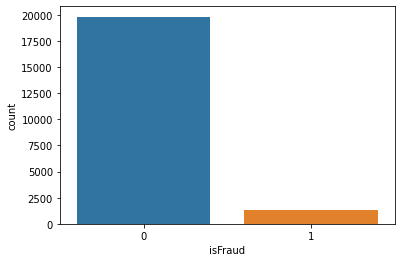

In [ ]:
print("fraud percentage =", y_train[y_train==1].sum() / len(y_train))
sns.countplot(y_train);

<font color='red'>**As we can see, the data suffers from a huge label imbalance.**<font>

# **Feature Engineering**

## Targeted Pro Feature

<font color='red'>**This feature indicates when a customer suggested some specific worker to do the job and that suggested worker will do the job. (ProId == TargetProId)**</font>

Text(0, 0.5, 'percentage')

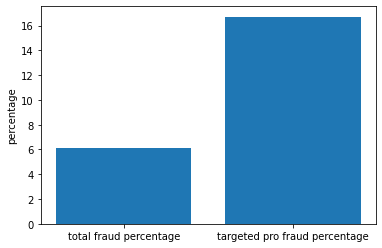

In [ ]:
targeted_pro = y_train[X_train.TargetProId == X_train.ProId].replace({True: 1, False: 0})
compare_list = [(y_train[y_train==1].size/y_train.size*100)
                , (targeted_pro[targeted_pro==1].size/targeted_pro.size*100)]
plt.bar(['total fraud percentage', 'targeted pro fraud percentage'], compare_list)
plt.ylabel('percentage')

<font color='red'>**As shown in the plot, fraud percentage in those scenarios are higher than total.**</font>

In [ ]:
TargetProId_ix, ProId_ix, = 11, 0

class TargetedProTransformer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    TargetedPro = (X[:, TargetProId_ix] == X[:, ProId_ix]).astype(int)
    return np.c_[X, TargetedPro]

In [ ]:
fraud = TargetedProTransformer()
f = fraud.fit_transform(X_train.values, y_train)

## TargetProId Missing Values

In [ ]:
X_train.isna().sum() / X_train.size

ProId                    0.000000
ProCreationTimestamp     0.000000
CustId                   0.000000
CustCreationTimestamp    0.000000
Rate                     0.000000
TaskCreationTimestamp    0.000000
Price                    0.019991
ServiceId                0.000000
CategoryId               0.000000
ZoneId                   0.000000
TaskState                0.000000
TargetProId              0.074845
dtype: float64

<BarContainer object of 12 artists>

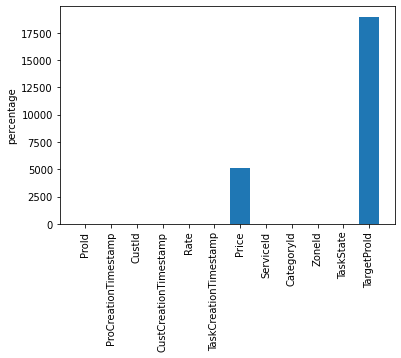

In [ ]:
plt.ylabel('percentage')
plt.xticks(rotation=90)
plt.bar(X_train.columns, X_train.isna().sum())

<font color='red'>**Due to the high number of missing values, this feature will be dropped.**<font>

## Price Outliers

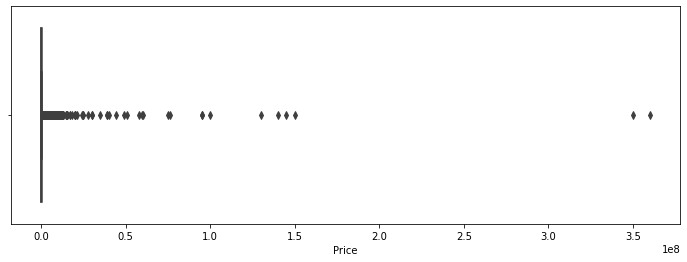

In [ ]:
plt.figure(figsize=(12,4))
sns.boxplot(x=X_train.Price)

In [ ]:
THRESHOLD = 60000000
rows_with_outlier = y_train[X_train.Price > THRESHOLD]

Text(0, 0.5, 'percentage')

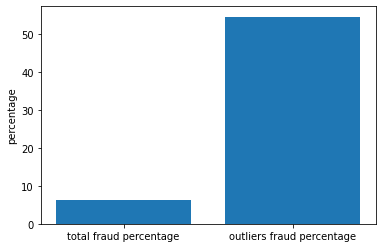

In [ ]:
compare_list = [(y_train[y_train==1].size/y_train.size*100)
                , (rows_with_outlier[rows_with_outlier==True].size/rows_with_outlier.size*100)]
plt.bar(['total fraud percentage', 'outliers fraud percentage'], compare_list)
plt.ylabel('percentage')

<font color='red'>**Here we can see that the fraud percentage in the outliers are high therefore I went with keeping the outliers to achieve a better model.**<font>

## Fraudulent Feature (based on time series)

<font color='red'>**The following feature is the most complicated one. The basic idea is that any worker with a fraud percentage more than 6% (based on the dataset) is a suspect to committing a fraud. But using this explanation by itself would be wrong since we are considering the time-series in our dataset. So we need to consider the timestamps of the created tasks. In order to do that, for each sample from the dataset, we take all the samples whose TaskCreationTimestamp is before the current row and then we calculate the average and decide based on that.**<font>

In [ ]:
ProId_ix, ProCreationTimestamp_ix, TaskCreationTimestamp_ix = 0, 1, 5

class FraudulentTransform(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.pros = []

  def fit(self, X, y=None):
    self.xt = X
    self.yt = y
    return self

  def transform(self, X):
    Fraudulent = []
    i = 0
    
    for r in X:
      tempX = self.xt[r[TaskCreationTimestamp_ix] > self.xt[:, TaskCreationTimestamp_ix]]
      tempY = self.yt[r[TaskCreationTimestamp_ix] > self.xt[:, TaskCreationTimestamp_ix]]
      if ((tempY.size == 0) | (tempY[tempX[:, ProId_ix]==r[ProId_ix]].size == 0)) :
        i = i+1
        Fraudulent.append(False)
      else :
        totalAvgFraud = tempY[tempY==1].size/tempY.size
        rAvgFraud = tempY[(tempX[:, ProId_ix]==r[ProId_ix]) & (tempY==1)].size/tempY[tempX[:, ProId_ix]==r[ProId_ix]].size
        Fraudulent.append(rAvgFraud > totalAvgFraud)
    Fraudulent = np.array(Fraudulent).astype(int)
    return np.concatenate((X, Fraudulent.reshape(len(Fraudulent),1)), axis=1)

In [ ]:
fraud = FraudulentTransform()
f = fraud.fit_transform(X_train.values, y_train)

Text(0, 0.5, 'percentage')

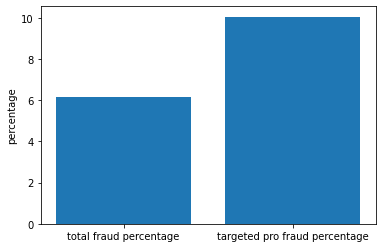

In [ ]:
compare_list = [(y_train[y_train==1].size/y_train.size*100)
                , (len(f[(f[:, 12]==1) & (y_train==1)]) / len(f[(f[:, 12]==1)])*100)]
plt.bar(['total fraud percentage', 'targeted pro fraud percentage'], compare_list)
plt.ylabel('percentage')

## (Task Timestamp - Pro Timestamp) Feature

In [ ]:
X_train.corrwith(y_train)

ProCreationTimestamp     0.097701
CustCreationTimestamp    0.057078
Rate                     0.045809
TaskCreationTimestamp    0.045519
Price                    0.061427
dtype: float64

In [ ]:
print("(Task Timestamp - Cust Timestamp) correlation =",pd.DataFrame(y_train).corrwith(X_train.TaskCreationTimestamp - X_train.CustCreationTimestamp))
print()
print("(Task Timestamp - Pro Timestamp) correlation =",pd.DataFrame(y_train).corrwith(X_train.TaskCreationTimestamp - X_train.ProCreationTimestamp))

(Task Timestamp - Cust Timestamp) correlation = isFraud   -0.025008
dtype: float64

(Task Timestamp - Pro Timestamp) correlation = isFraud   -0.072705
dtype: float64


<font color='red'>**This feature shows the relation between worker creation in the website and the task creation. As seen above, the correlation is a bit higher than the other features so we could conclude that this might be a helpful feature. In short, this feature tries to tell us that the longer a worker has its account, the lower is the fraud.</br>Note that this fact is not the same for customer accounts.**<font>

In [ ]:
ProCreationTimestamp_ix, TaskCreationTimestamp_ix, = 1, 5

class TimeStampTransformer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    TargetedPro = X[:, ProCreationTimestamp_ix] - X[:, TaskCreationTimestamp_ix]
    return np.c_[X, TargetedPro]

## Timestamps

In [ ]:
X_train[['ProCreationTimestamp', 'CustCreationTimestamp', 'TaskCreationTimestamp']].corrwith(y_train)

ProCreationTimestamp     0.097701
CustCreationTimestamp    0.057078
TaskCreationTimestamp    0.045519
dtype: float64

<font color='red'>**Due to the low correlation, customer and task creation time will be dropped.**<font>

## IDs

In [ ]:
print("number of categorieis of ProId =", len(X_train.ProId.value_counts()))
print("number of categorieis of CustId =", len(X_train.CustId.value_counts()))
print("number of categorieis of ServiceId =", len(X_train.ServiceId.value_counts()))
print("number of categorieis of CategoryId =", len(X_train.CategoryId.value_counts()))
print("number of categorieis of ZoneId =", len(X_train.ZoneId.value_counts()))

number of categorieis of ProId = 3860
number of categorieis of CustId = 16876
number of categorieis of ServiceId = 211
number of categorieis of CategoryId = 8
number of categorieis of ZoneId = 43


<font color='red'>**We don't need the IDs so they will be dropped too but the CategoryId is kept because of both its low number of unique values and because I thought it would be a good idea to keep this feature.</br>Since there is no numerical relation between the categories, this feature will be one-hotted.**</font>

## Task State

In [ ]:
X_train.TaskState.value_counts()

Finished    21124
Canceled        1
Waiting         1
Name: TaskState, dtype: int64

<font color='red'>**This feature actually does not help us at all since almost all the values belong to one label.**<font>

## Price Missing Values

In [ ]:
X_train.isna().sum() / X_train.size

ProId                    0.000000
ProCreationTimestamp     0.000000
CustId                   0.000000
CustCreationTimestamp    0.000000
Rate                     0.000000
TaskCreationTimestamp    0.000000
Price                    0.019991
ServiceId                0.000000
CategoryId               0.000000
ZoneId                   0.000000
TaskState                0.000000
TargetProId              0.074845
dtype: float64

<font color='red'>**Since there are a few number of missing values in the Price feature, we are going to fill the missing values with the average of that feature.**<font>

## Drop Transformer

In [ ]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin


class DropSomeColumns(BaseEstimator, TransformerMixin):
  def __init__(self, cols):
    if not isinstance(cols, list):
      self.cols = [cols]
    else:
      self.cols = cols

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    c = np.delete(np.arange(X.shape[1]), self.cols)
    X = X.copy()
    return X[:,c]

# **Pipeline**

In [ ]:
# droped colums : ProId_ix, CustId_ix, ServiceId_ix, CategoryId, ZoneId_ix, CustCreationTimestamp_ix, TaskCreationTimestamp_ix, TargetProId_ix, TaskState
droped_columns = [0, 2, 7, 8, 9, 3, 5, 11, 10]

p = Pipeline([
              ('targeted_pro', TargetedProTransformer()),
              ('fraudlent', FraudulentTransform()),
              ('timestamp', TimeStampTransformer()),
              ('drop_some_columns', DropSomeColumns(droped_columns)),
              ('imputer', SimpleImputer(strategy="mean")),
              ('std_scaler', StandardScaler())
              ])

In [ ]:
encoder = OneHotEncoder()
X_train_1hot = encoder.fit_transform(X_train[['CategoryId']])
X_train_cleaned_without_1hot = p.fit_transform(X_train.values, y_train)
X_train_cleaned = np.concatenate((X_train_cleaned_without_1hot, X_train_1hot.toarray()), axis=1)

In [ ]:
X_test_1hot = encoder.transform(X_test[['CategoryId']])
X_test_cleaned_without_1hot = p.transform(X_test.values)
X_test_cleaned = np.concatenate((X_test_cleaned_without_1hot, X_test_1hot.toarray()), axis=1)

# **Handle Imbalanced Dataset**

In [ ]:
print(Counter(y_train))

Counter({0: 19827, 1: 1299})


<font color='red'>**I tried to fix the imbalance using a mixed sampling. The minority labels are upsampled to a specific percentage and the majority labels are undersampled.**<font>

In [ ]:
over = SMOTE(sampling_strategy=0.1, random_state=58)
under = RandomUnderSampler(sampling_strategy=0.2, random_state=58)

pipeline = imPipeline(steps = [('o', over), ('u', under)])

In [ ]:
X_train_cleaned, y_train = pipeline.fit_resample(X_train_cleaned, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print(Counter(y_train))

Counter({0: 9910, 1: 1982})


# **Model**

## Evaluate Model

<font color='red'>**Since the accuracy is generally biased, I used recall and F1-score for evaluation metrics. Since we do not want to miss out any fraudulent orders, the RECALL is more important that the precision to us.**<font>

In [ ]:
def eval(y_pred, y_test):
  recall = recall_score(y_test, y_pred, average='binary')
  print('Recall: %.3f' % recall)
  f1 = f1_score(y_test, y_pred, average='binary')
  print('F1: %.3f' % f1)
  cm = confusion_matrix(y_test, y_pred)
  print(cm)
  acc = accuracy_score(y_test, y_pred)
  print('Accuracy: %.3f' % acc)

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision") 
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

## Training Model

### RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train_cleaned, y_train)
y_pred_proba = clf.predict_proba(X_test_cleaned)

In [ ]:
y_pred = (y_pred_proba[:,1] >= 0.3).astype('int')
eval(y_pred, y_test)

Recall: 0.485
F1: 0.323
[[3121  367]
 [ 124  117]]
Accuracy: 0.868


In [ ]:
roc_auc_score(y_test, y_pred)

0.6901296442574898

### AdaBoostClassifier

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), 
    n_estimators=200,
    algorithm="SAMME.R",
    learning_rate=0.5,
    )
ada_clf.fit(X_train_cleaned, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [ ]:
y_pred = (y_pred_proba[:,1] >= 0.5).astype('int')
eval(y_pred, y_test)

Recall: 0.307
F1: 0.333
[[3358  130]
 [ 167   74]]
Accuracy: 0.920


In [ ]:
roc_auc_score(y_test, y_pred)

0.6348916498534394

### SVC

In [ ]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='sigmoid')
svclassifier.fit(X_train_cleaned, y_train)

y_pred = svclassifier.predict(X_test_cleaned)

In [ ]:
roc_auc_score(y_test, y_pred)

0.5457983983021814

In [ ]:
eval(y_pred, y_test)

Recall: 0.232
F1: 0.142
[[2997  491]
 [ 185   56]]
Accuracy: 0.819


### XGBClassifier

In [ ]:
from xgboost import XGBClassifier
xgb_reg = XGBClassifier(
    n_estimators=400,
    learning_rate=0.1,
    )
xgb_reg.fit(X_train_cleaned, y_train, eval_metric=recall_score)

y_pred_proba = xgb_reg.predict_proba(X_test_cleaned)

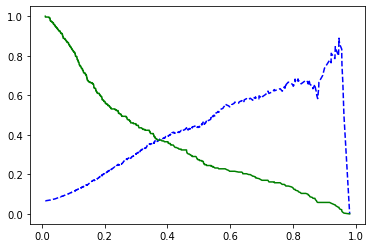

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba[:,1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [ ]:
y_pred = (y_pred_proba[:,1] >= 0.23).astype('int')
eval(y_pred, y_test)

Recall: 0.531
F1: 0.326
[[3072  416]
 [ 113  128]]
Accuracy: 0.858


In [ ]:
roc_auc_score(y_test, y_pred)

0.705927138452168

## Grid Search

<font color='red'>**The best model was "XGBoost Classifier". Next, we will try to find the best parameters for this model.**<font>

In [ ]:
param_grid = [
        {'n_estimators': [50, 100, 600], 'max_features': [2, 4, 8], 'bootstrap': [False]},
]

xgb_reg = XGBClassifier()
grid_search = GridSearchCV(xgb_reg,
                           param_grid,
                           cv=5,
                           scoring='recall',
                           return_train_score=False)

grid_search.fit(X_train_cleaned, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=None,
             param_grid=[{'bootstrap': [False], 'max_features': [2, 4, 8],
                          'n_estimators': [50, 100, 600]}],
             pre_dispatch='2*n_jobs', refi

In [ ]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 2, 'n_estimators': 600}

## Final Model

<font color='red'>**All in all, in this project, I tried to delete/add some features logically. After some change to the dataset, I fixed the imbalance problem using a mixture of sampling, and then after using a bunch of different models, "XGBoost" was the best one. Then I tried different hyperparameters, and after finding the best ones, these are the final and final results.**<font>

In [ ]:
final_model = XGBClassifier(
    n_estimators=600,
    learning_rate=0.1,
    max_features=2,
    )
final_model.fit(X_train_cleaned, y_train, eval_metric=recall_score)

y_pred_proba = final_model.predict_proba(X_test_cleaned)
y_pred = (y_pred_proba[:,1] >= 0.19).astype('int')

In [ ]:
eval(y_pred, y_test)

Recall: 0.602
F1: 0.298
[[2900  588]
 [  96  145]]
Accuracy: 0.817
